# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
!pip install pycaret

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
data = pd.read_feather('/content/credit_scoring.ftr')
data['mau'] = data.mau.astype('int64')
data = data.sample(50000)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df_oot = data.copy().query("data_ref >= '2016-01-01'")
df = data.copy().query("data_ref < '2016-01-01'")

variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau']

In [4]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [5]:
metadados = pd.DataFrame(df[variaveis].dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.001113
posse_de_veiculo,object,0.0,2.0,covariavel,0.000013
posse_de_imovel,object,0.0,2.0,covariavel,0.010925
qtd_filhos,int64,0.0,8.0,covariavel,0.000110
tipo_renda,object,0.0,5.0,covariavel,0.008531
educacao,object,0.0,5.0,covariavel,0.006787
estado_civil,object,0.0,5.0,covariavel,0.005201
tipo_residencia,object,0.0,6.0,covariavel,0.005422
idade,int64,0.0,47.0,covariavel,0.020371
tempo_emprego,float64,6777.0,2932.0,covariavel,0.382981


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
df.groupby('data_ref').count()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,,
2015-01-01,3326,3326,3326,3326,3326,3326,3326,3326,3326,3326,2729,3326,3326,3326
2015-02-01,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212,2654,3212,3212,3212
2015-03-01,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,2851,3382,3382,3382
2015-04-01,3303,3303,3303,3303,3303,3303,3303,3303,3303,3303,2732,3303,3303,3303
2015-05-01,3417,3417,3417,3417,3417,3417,3417,3417,3417,3417,2867,3417,3417,3417
2015-06-01,3258,3258,3258,3258,3258,3258,3258,3258,3258,3258,2702,3258,3258,3258
2015-07-01,3347,3347,3347,3347,3347,3347,3347,3347,3347,3347,2761,3347,3347,3347
2015-08-01,3301,3301,3301,3301,3301,3301,3301,3301,3301,3301,2757,3301,3301,3301
2015-09-01,3334,3334,3334,3334,3334,3334,3334,3334,3334,3334,2733,3334,3334,3334


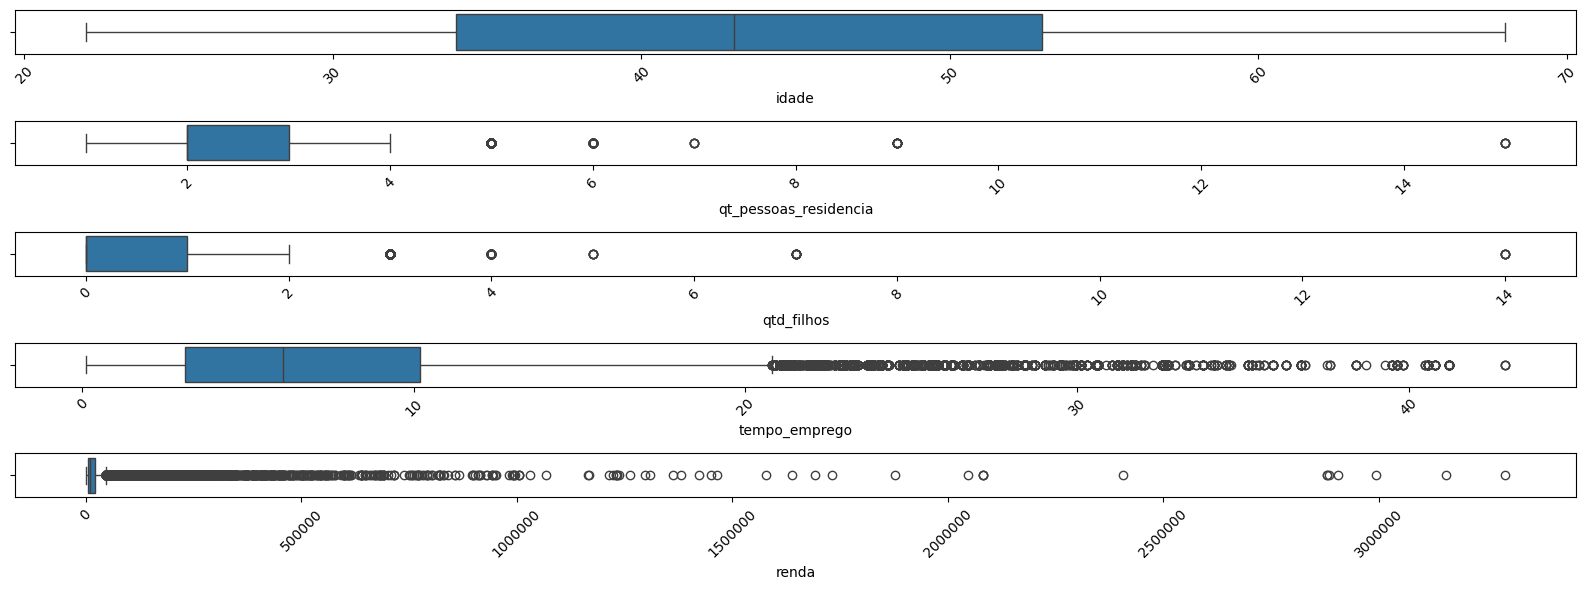

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16, 6))
continuas = ['idade', 'qt_pessoas_residencia', 'qtd_filhos', 'tempo_emprego', 'renda']

for i, var in enumerate(continuas):
    sns.boxplot(ax=axes[i], x=df[var])
    axes[i].ticklabel_format(style='plain', axis='x')  # Configura os números no formato "plain" (sem notação científica)
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)  # Rotaciona os ticks do eixo X se necessário

plt.tight_layout()
plt.show()

<Axes: xlabel='renda'>

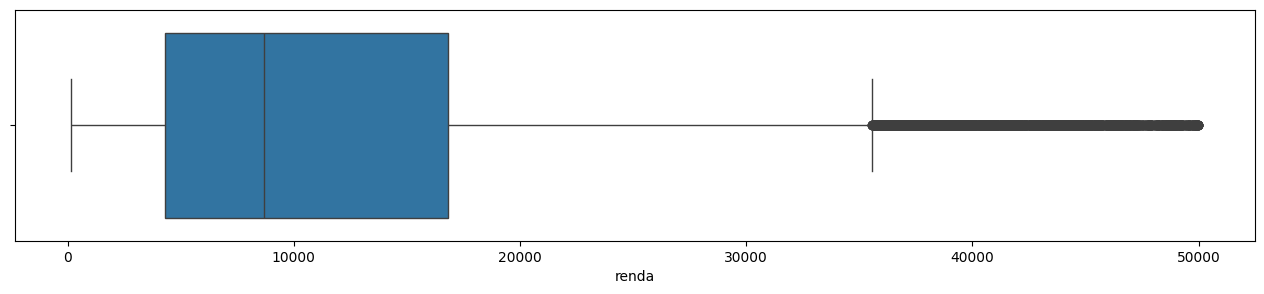

In [8]:
df = df.query('renda < 50000')
df_oot = df_oot.query('renda < 50000')

fig, ax = plt.subplots(figsize=(16, 3))
sns.boxplot(ax=ax, x=df['renda'])

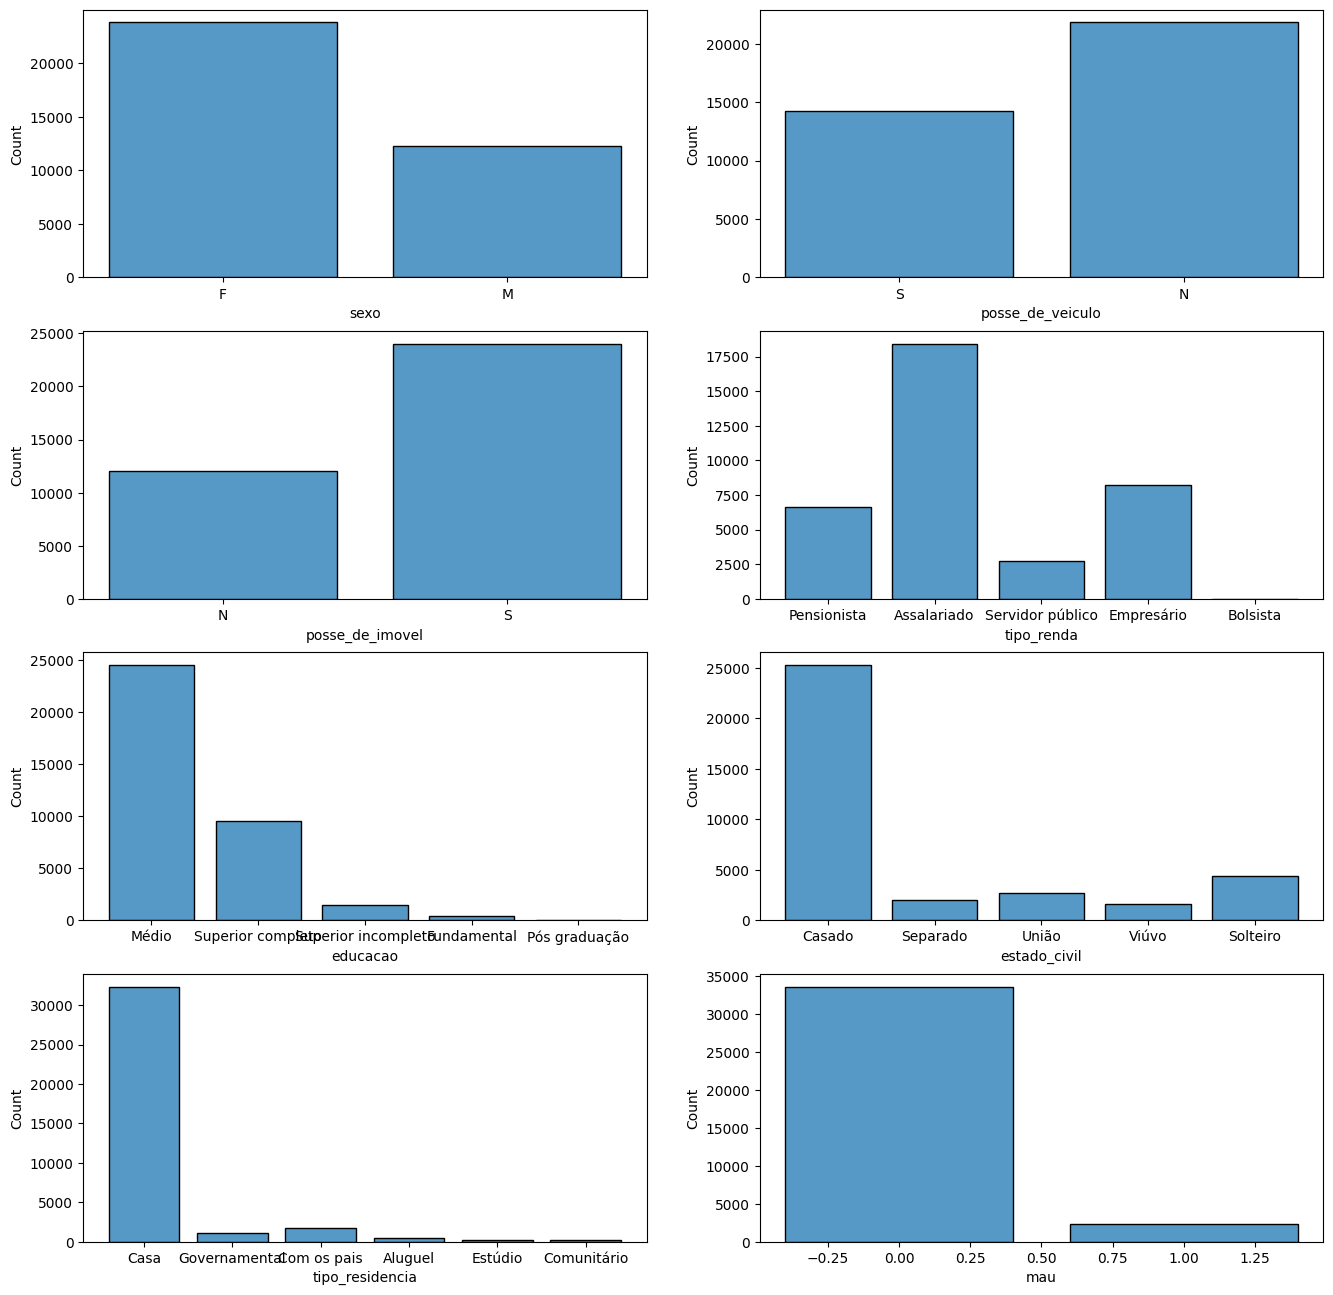

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
discretas = [var for var in variaveis if var not in continuas]


for i, var in enumerate(discretas):
    sns.histplot(ax=axes[i//2][i%2], x=df[var], binwidth=.5, discrete=True, shrink=.8)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [10]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()

    return display(biv)


def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return display(biv)

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,22180,1611,0.067715,F,23791,0.001629,0.070908,0.064522,-2.622336,-2.572831,-2.674054,0.039975,0.089479,-0.011744
M,11494,739,0.060410,M,12233,0.002154,0.064633,0.056188,-2.744283,-2.672219,-2.821223,-0.081972,-0.009909,-0.158912


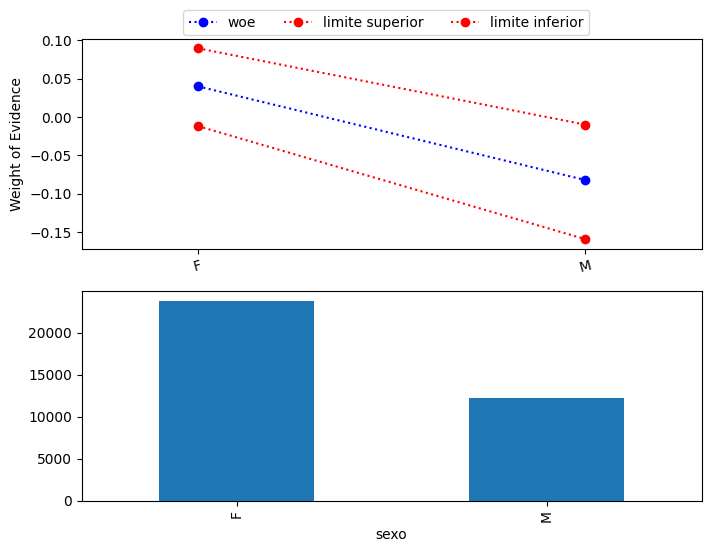

In [11]:
biv_discreta(discretas[0], df);

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,20392,1429,0.065487,N,21821,0.001675,0.068770,0.062205,-2.658168,-2.605740,-2.713098,0.004143,0.056570,-0.050788
S,13282,921,0.064845,S,14203,0.002066,0.068896,0.060795,-2.668705,-2.603778,-2.737522,-0.006394,0.058532,-0.075211


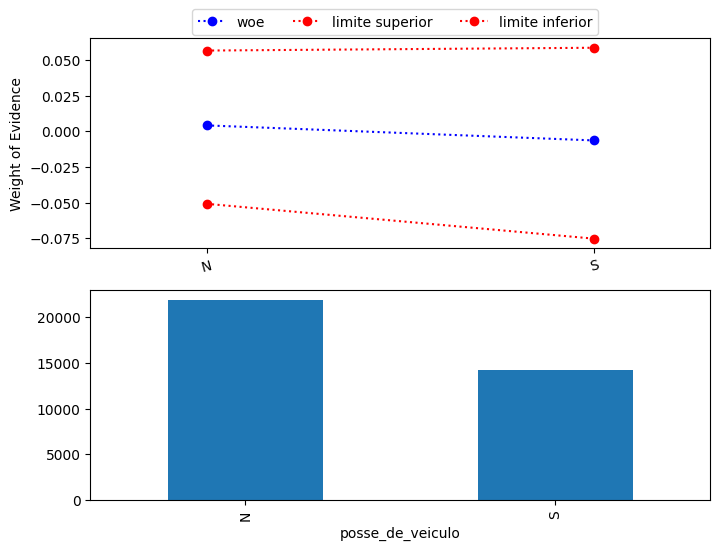

In [12]:
biv_discreta(discretas[1], df);

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,11116,885,0.073744,N,12001,0.002386,0.078420,0.069067,-2.530553,-2.464007,-2.601103,0.131758,0.198304,0.061208
S,22558,1465,0.060983,S,24023,0.001544,0.064009,0.057957,-2.734235,-2.682575,-2.788349,-0.071924,-0.020264,-0.126038


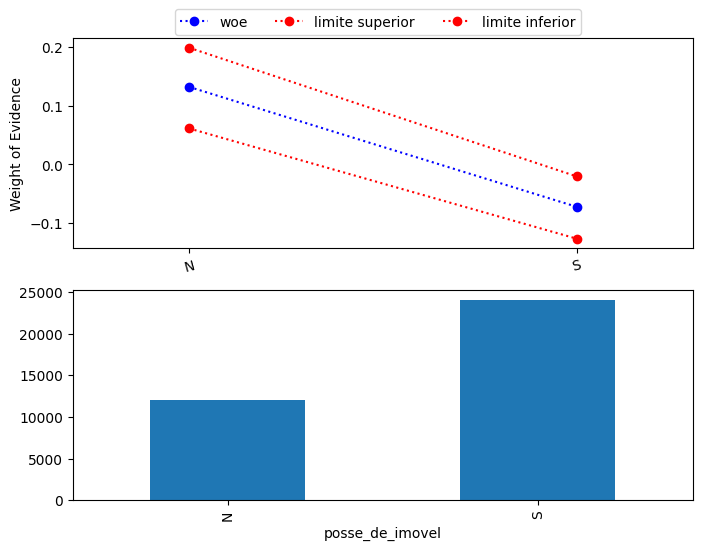

In [13]:
biv_discreta(discretas[2], df);

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,17162,1262,0.068498,Assalariado,18424,0.001861,0.072145,0.064850,-2.610000,-2.554193,-2.668631,0.052311,0.108117,-0.006320
Bolsista,18,1,0.052632,Bolsista,19,0.051228,0.160257,-0.054994,-2.890372,-1.656315,NaN,-0.228061,1.005995,NaN
Empresário,7666,530,0.064666,Empresário,8196,0.002717,0.069991,0.059341,-2.671673,-2.586830,-2.763288,-0.009363,0.075481,-0.100978
Pensionista,6243,409,0.061485,Pensionista,6652,0.002945,0.067259,0.055712,-2.725501,-2.629577,-2.830245,-0.063190,0.032734,-0.167934
Servidor público,2585,148,0.054153,Servidor público,2733,0.004329,0.062642,0.045664,-2.860269,-2.705635,-3.039700,-0.197958,-0.043324,-0.377390


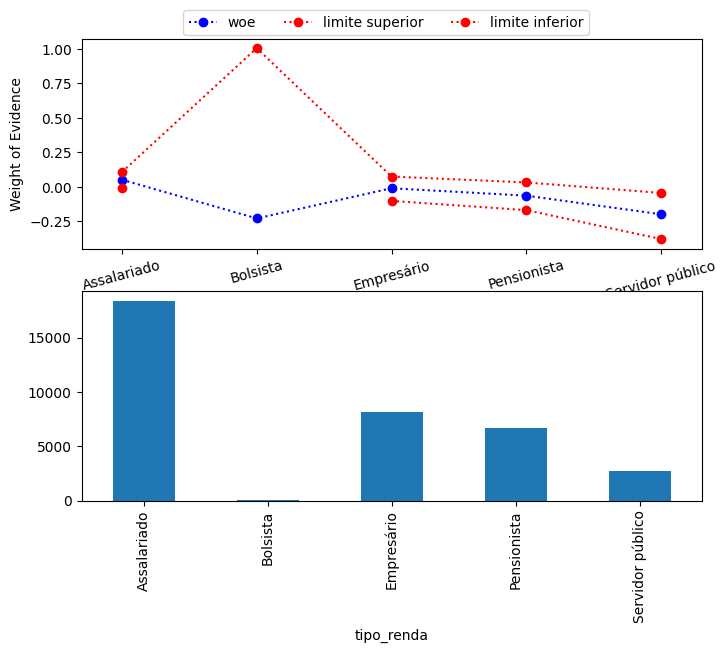

In [14]:
biv_discreta(discretas[3], df);

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado/Bolsista,17180,1263,0.068481,Assalariado/Bolsista,18443,0.001860,0.072127,0.064836,-2.610256,-2.554472,-2.668863,0.052055,0.107839,-0.006552
Empresário,7666,530,0.064666,Empresário,8196,0.002717,0.069991,0.059341,-2.671673,-2.586830,-2.763288,-0.009363,0.075481,-0.100978
Pensionista,6243,409,0.061485,Pensionista,6652,0.002945,0.067259,0.055712,-2.725501,-2.629577,-2.830245,-0.063190,0.032734,-0.167934
Servidor público,2585,148,0.054153,Servidor público,2733,0.004329,0.062642,0.045664,-2.860269,-2.705635,-3.039700,-0.197958,-0.043324,-0.377390


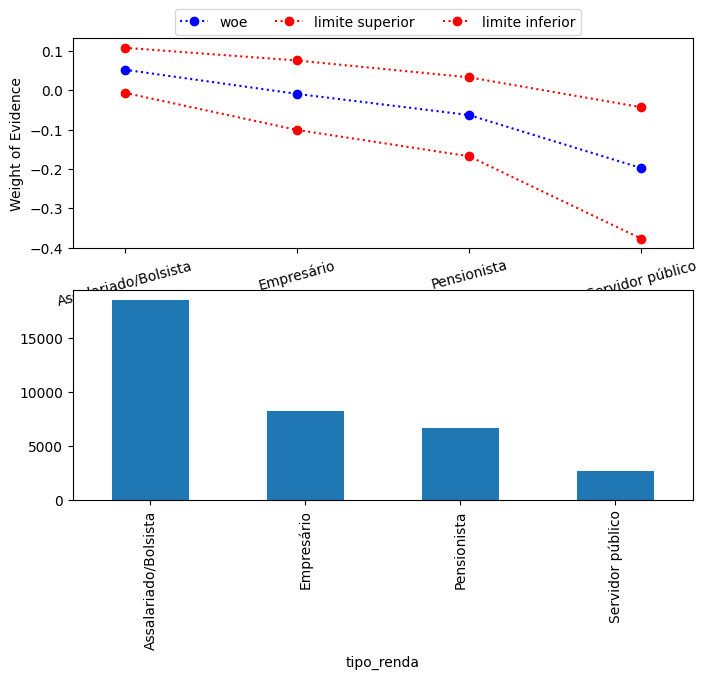

In [15]:
df2 = df.copy()
df_oot2 = df_oot.copy()
df2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
df_oot2.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista', 'Bolsista': 'Assalariado/Bolsista'}, inplace=True)
biv_discreta('tipo_renda', df2)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,386,34,0.080952,Fundamental,420,0.013309,0.107114,0.054791,-2.429477,-2.120566,-2.847883,0.232834,0.541745,-0.185573
Médio,22865,1659,0.067648,Médio,24524,0.001604,0.070791,0.064505,-2.623392,-2.574596,-2.674338,0.038918,0.087714,-0.012028
Pós graduação,33,2,0.057143,Pós graduação,35,0.039235,0.136877,-0.022592,-2.803360,-1.841472,NaN,-0.141050,0.820839,NaN
Superior completo,8989,581,0.060711,Superior completo,9570,0.002441,0.065496,0.055926,-2.739006,-2.658035,-2.826183,-0.076695,0.004276,-0.163872
Superior incompleto,1401,74,0.050169,Superior incompleto,1475,0.005684,0.061319,0.039020,-2.940876,-2.728388,-3.203877,-0.278566,-0.066077,-0.541566


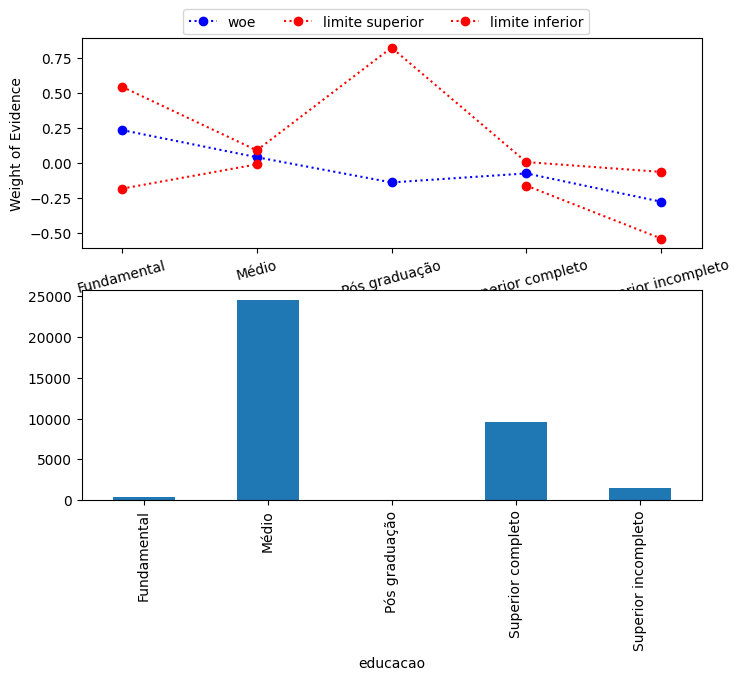

In [16]:
biv_discreta(discretas[4], df);

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental/Médio,23251,1693,0.067872,Fundamental/Médio,24944,0.001593,0.070994,0.064750,-2.619846,-2.571526,-2.670272,0.042465,0.090784,-0.007961
Superior,10423,657,0.059296,Superior,11080,0.002244,0.063694,0.054898,-2.764086,-2.687850,-2.845817,-0.101775,-0.025539,-0.183507


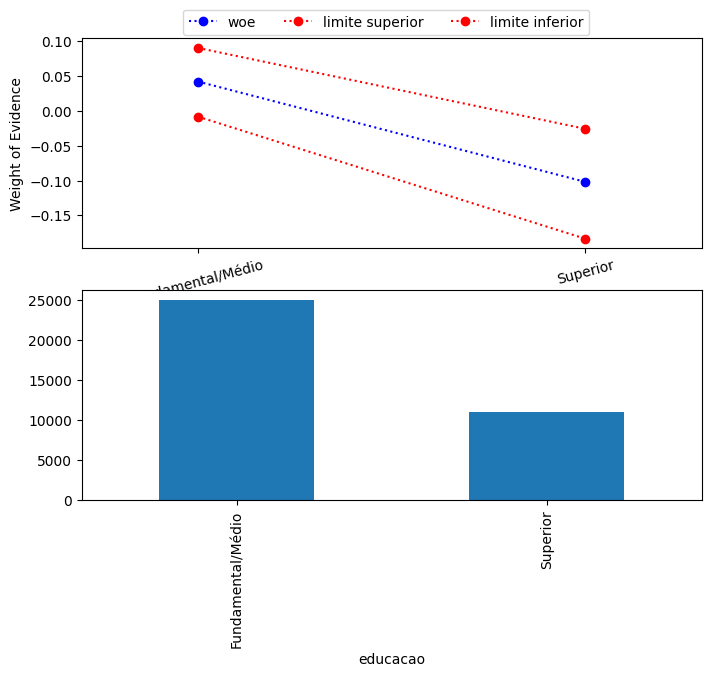

In [17]:
df2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
df_oot2.educacao.replace({'Fundamental': 'Fundamental/Médio', 'Médio': 'Fundamental/Médio'}, inplace=True)
df_oot2.educacao.replace({'Pós graduação': 'Superior', 'Superior completo': 'Superior', 'Superior incompleto': 'Superior'}, inplace=True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,23692,1586,0.062742,Casado,25278,0.001525,0.065732,0.059753,-2.703922,-2.654180,-2.755928,-0.041612,0.008131,-0.093617
Separado,1877,164,0.080353,Separado,2041,0.006017,0.092153,0.068552,-2.437564,-2.287624,-2.609141,0.224747,0.374687,0.053169
Solteiro,4087,303,0.069021,Solteiro,4390,0.003826,0.076521,0.061520,-2.601834,-2.490582,-2.724901,0.060477,0.171729,-0.062590
União,2533,200,0.073180,União,2733,0.004982,0.082948,0.063411,-2.538842,-2.402952,-2.692599,0.123468,0.259358,-0.030289
Viúvo,1485,97,0.061315,Viúvo,1582,0.006032,0.073146,0.049484,-2.728459,-2.539342,-2.955359,-0.066148,0.122968,-0.293049


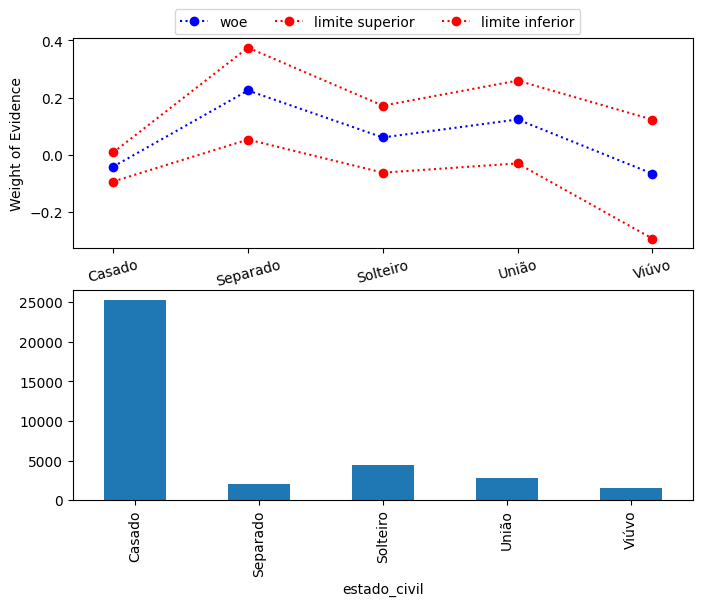

In [18]:
biv_discreta(discretas[5], df);

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,461,42,0.083499,Aluguel,503,0.012335,0.107733,0.059265,-2.395728,-2.114113,-2.764637,0.266582,0.548198,-0.102326
Casa,30280,2081,0.064306,Casa,32361,0.001364,0.066978,0.061633,-2.677639,-2.634057,-2.722941,-0.015328,0.028254,-0.060631
Com os pais,1541,132,0.078900,Com os pais,1673,0.006591,0.091827,0.065973,-2.457385,-2.291523,-2.650261,0.204926,0.370788,0.012049
Comunitário,141,11,0.072368,Comunitário,152,0.021016,0.113891,0.030846,-2.550865,-2.051599,-3.447418,0.111446,0.610712,-0.785108
Estúdio,239,13,0.051587,Estúdio,252,0.013934,0.079029,0.024145,-2.911514,-2.455608,-3.699227,-0.249203,0.206702,-1.036917
Governamental,1012,71,0.065559,Governamental,1083,0.007521,0.080316,0.050801,-2.657004,-2.438060,-2.927698,0.005307,0.224250,-0.265388


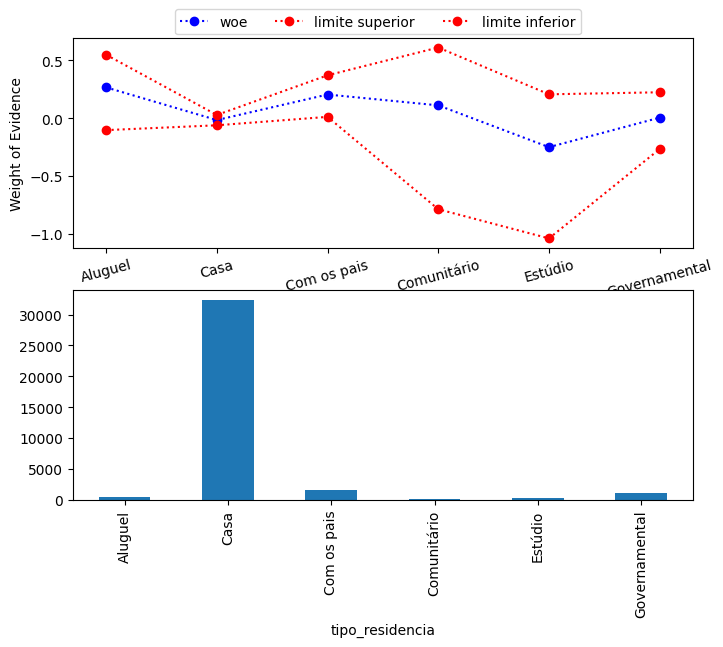

In [19]:
biv_discreta(discretas[6], df);

<ipython-input-10-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 32.0]",7105,558,0.072817,28.780504,7663,0.002968,0.078636,0.066999,-2.544195,-2.461025,-2.633731,0.118116,0.201285,0.028580
"(32.0, 39.0]",6982,520,0.069315,36.049453,7502,0.002932,0.075063,0.063566,-2.597262,-2.511395,-2.689992,0.065049,0.150916,-0.027681
"(39.0, 46.0]",6378,443,0.064946,42.823340,6821,0.002984,0.070796,0.059097,-2.667040,-2.574530,-2.767655,-0.004729,0.087780,-0.105344
"(46.0, 55.0]",6524,406,0.058586,50.844877,6930,0.002821,0.064116,0.053056,-2.776890,-2.680796,-2.881900,-0.114579,-0.018485,-0.219589
"(55.0, 68.0]",6685,423,0.059510,60.528278,7108,0.002806,0.065011,0.054010,-2.760249,-2.665976,-2.863069,-0.097939,-0.003665,-0.200759


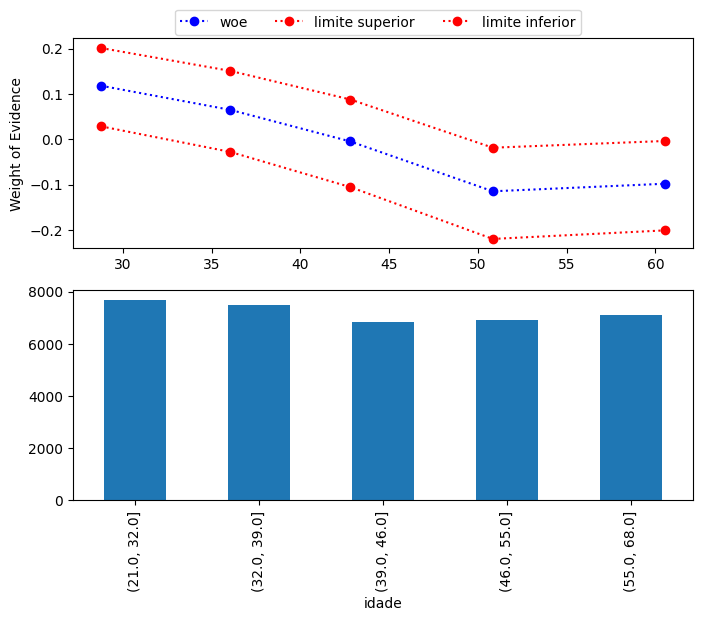

In [20]:
biv_continua(continuas[0], 5, df);

<ipython-input-10-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
"(0.0, 2.0]",23987,1660,0.064725,1.744337,25647,0.001536,0.067736,0.061714,-2.670694,-2.621995,-2.721551,-0.008384,0.040316,-0.059240
"(2.0, 3.0]",6080,447,0.068485,3.000000,6527,0.003126,0.074613,0.062356,-2.610201,-2.517892,-2.710508,0.052109,0.144419,-0.048198
"(3.0, 4.0]",3141,203,0.060706,4.000000,3344,0.004129,0.068802,0.052609,-2.739091,-2.605238,-2.890816,-0.076780,0.057073,-0.228506
"(4.0, 15.0]",466,40,0.079051,5.306324,506,0.011995,0.102617,0.055485,-2.455306,-2.168474,-2.834553,0.207005,0.493837,-0.172242


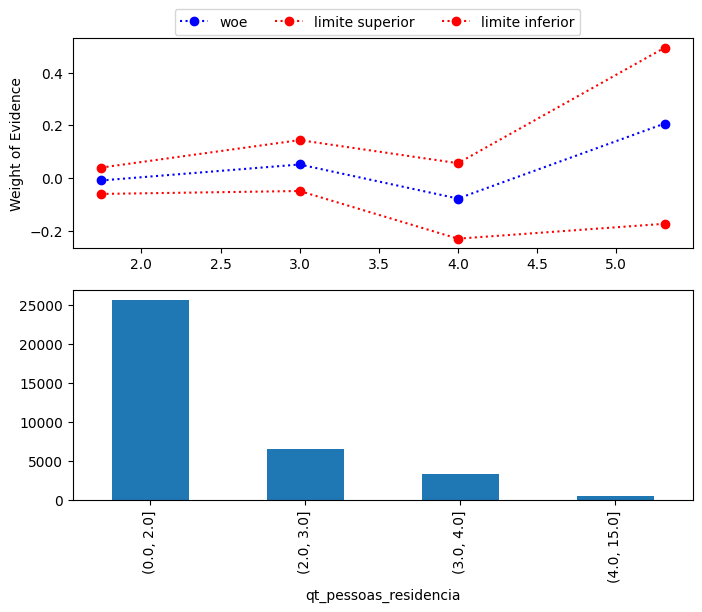

In [21]:
biv_continua(continuas[1], 12, df);

<ipython-input-10-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
"(-1.0, 1.0]",29911,2086,0.065194,0.237679,31997,0.001380,0.067899,0.062489,-2.662978,-2.619425,-2.708245,-0.000667,0.042885,-0.045935
"(1.0, 2.0]",3284,223,0.063587,2.000000,3507,0.004121,0.071666,0.055508,-2.689646,-2.561376,-2.834115,-0.027335,0.100935,-0.171804
"(2.0, 14.0]",479,41,0.078846,3.309615,520,0.011818,0.102064,0.055629,-2.458129,-2.174502,-2.831822,0.204182,0.487809,-0.169512


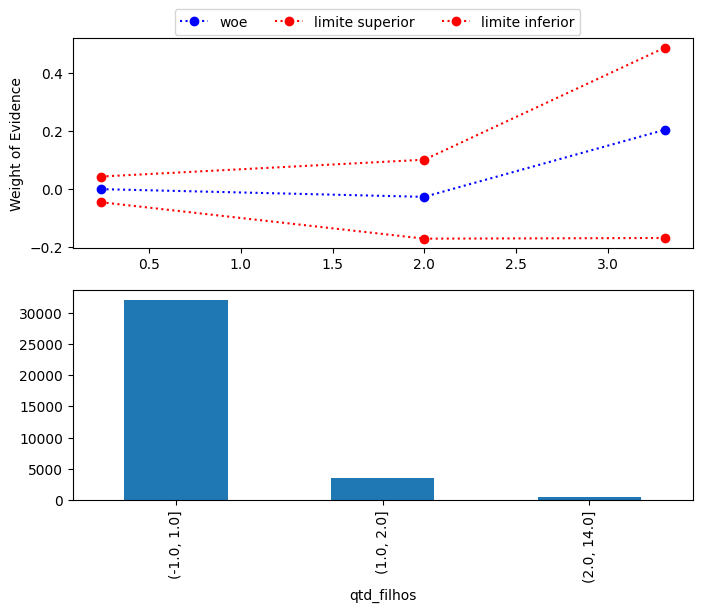

In [22]:
biv_continua(continuas[2], 10, df);

<ipython-input-10-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 2.0]",5267,613,0.104252,1.120347,5880,0.003985,0.112064,0.096439,-2.150851,-2.069829,-2.237429,0.511459,0.592482,0.424881
"(2.0, 4.0]",5387,489,0.083220,3.258311,5876,0.003603,0.090284,0.076156,-2.399381,-2.310175,-2.495759,0.262929,0.352135,0.166551
"(4.0, 7.0]",5473,403,0.068584,5.357987,5876,0.003297,0.075048,0.062120,-2.608646,-2.511617,-2.714547,0.053665,0.150693,-0.052237
"(7.0, 10.0]",5621,254,0.043234,7.964019,5875,0.002653,0.048436,0.038032,-3.096931,-2.977868,-3.230545,-0.434620,-0.315557,-0.568235
"(10.0, 37.0]",5695,182,0.030968,13.726421,5877,0.002260,0.035398,0.026538,-3.443337,-3.305060,-3.602267,-0.781026,-0.642749,-0.939957


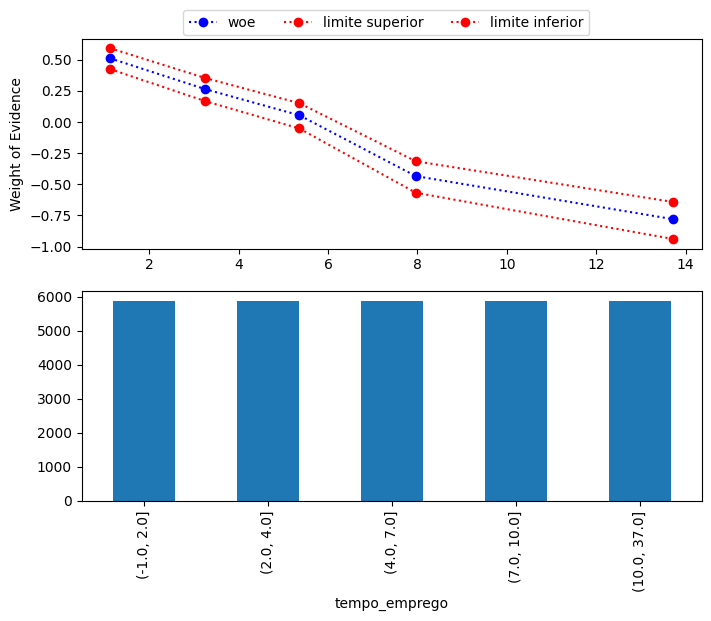

In [23]:
biv_continua(continuas[3], 5, df);

<ipython-input-10-19f05050ae0a>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 3638.0]",6004,1203,0.166921,2255.720486,7207,0.004393,0.175532,0.158310,-1.607607,-1.546918,-1.670855,1.054703,1.115393,0.991456
"(3638.0, 6689.0]",6701,503,0.069822,5084.054799,7204,0.003003,0.075708,0.063936,-2.589422,-2.502141,-2.683795,0.072889,0.160170,-0.021484
"(6689.0, 11247.0]",6846,357,0.049563,8767.087769,7203,0.002557,0.054576,0.044550,-2.953684,-2.852044,-3.065579,-0.291373,-0.189733,-0.403269
"(11247.0, 19574.0]",7009,197,0.027338,14824.156539,7206,0.001921,0.031104,0.023573,-3.571747,-3.438821,-3.723812,-0.909436,-0.776511,-1.061502
"(19574.0, 49993.0]",7114,90,0.012493,30245.782547,7204,0.001309,0.015058,0.009928,-4.370010,-4.180649,-4.602443,-1.707700,-1.518338,-1.940133


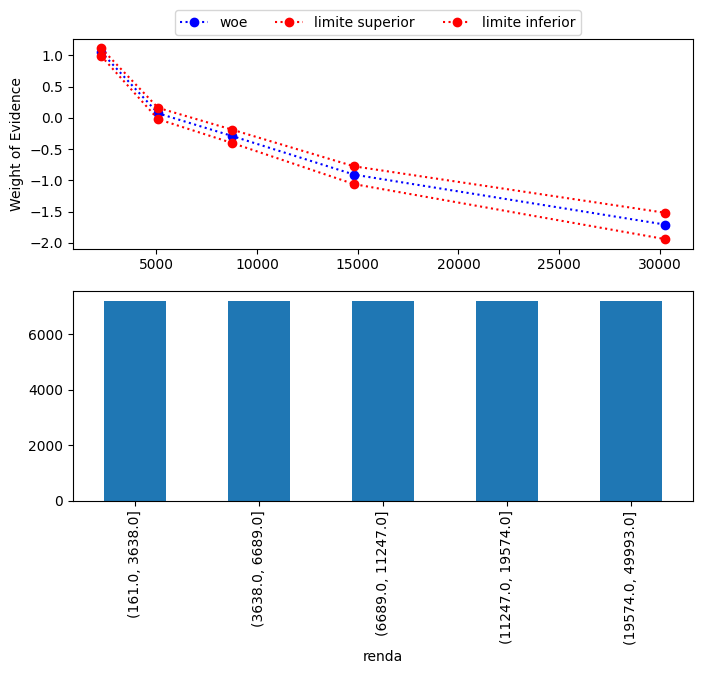

In [24]:
biv_continua(continuas[4], 5, df);

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [25]:
df2['tempo_emprego'] = df2['tempo_emprego'].fillna(df2['tempo_emprego'].mean())

In [26]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,33201.0,covariavel,0.956990
tempo_emprego,float64,6777.0,2932.0,covariavel,0.382981
idade,int64,0.0,47.0,covariavel,0.020371
posse_de_imovel,object,0.0,2.0,covariavel,0.010925
tipo_renda,object,0.0,5.0,covariavel,0.008531
educacao,object,0.0,5.0,covariavel,0.006787
tipo_residencia,object,0.0,6.0,covariavel,0.005422
estado_civil,object,0.0,5.0,covariavel,0.005201
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.001275
sexo,object,0.0,2.0,covariavel,0.001113


In [27]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df2['tempo_emprego_norm'] = sc_X.fit_transform(df2[['tempo_emprego']])
df2['renda_norm'] = sc_X.fit_transform(df2[['renda']])
df_oot2['tempo_emprego_norm'] = sc_X.fit_transform(df_oot2[['tempo_emprego']])
df_oot2['renda_norm'] = sc_X.fit_transform(df_oot2[['renda']])

formula = 'mau ~ sexo + tipo_renda + tempo_emprego_norm + renda_norm'

rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:                36024
Model:                            GLM   Df Residuals:                    36017
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7941.8
Date:                Sun, 17 Nov 2024   Deviance:                       15884.
Time:                        21:06:31   Pearson chi2:                 5.99e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04051
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.1529      0.047    -67.235      0.000      -3.245      -3.061
sexo[T.M]                         -0.0343      0.048     -0.718      0.473      -0.128       0.059
tipo_renda[T.Empresário]          -0.0466      0.055     -0.851      0.395      -0.154       0.061
tipo_renda[T.Pensionista]         -0.0830      0.062     -1.339      0.180      -0.205       0.038
tipo_renda[T.Servidor público]    -0.0285      0.092     -0.312      0.755      -0.208       0.151
tempo_emprego_norm                -0.1117      0.031     -3.602      0.000      -0.172      -0.051
renda_norm                        -1.3468      0.052    -26.101      0.000      -1.448      -1.246
==================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [28]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 93.48%
KS: 35.77% 
AUC: 74.33% 
GINI: 48.65%


In [29]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = rl.predict(df_oot2[['sexo', 'tipo_renda', 'tempo_emprego_norm', 'renda_norm']])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 85.12%
KS: 33.48% 
AUC: 72.88% 
GINI: 45.76%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

imputer = SimpleImputer(strategy='mean')

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.covariance import EllipticEnvelope

class EllipticEnvelopeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.envelope = EllipticEnvelope(contamination=self.contamination, support_fraction=0.9)

    def fit(self, X, y=None):
        self.envelope.fit(X)
        return self

    def transform(self, X, y=None):
        return self.envelope.predict(X).reshape(-1, 1)

outliers_removal = EllipticEnvelopeTransformer(contamination=0.1)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [32]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [33]:
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [34]:
dummies = OneHotEncoder(handle_unknown='ignore')

### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [35]:
numeric_features = continuas
categorical_features = discretas[:-1]


numeric_transformer = Pipeline(steps=[
    ('imputer', imputer),
    ('outliere_removal', outliers_removal),
])


categorical_transformer = Pipeline(steps=[
    ('dummy', dummies),
    ('feature_selector', feature_selector),
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca_pipe),
                           ('log_reg', LogisticRegression(max_iter=200))
                          ])


pipe.fit(df2[variaveis].iloc[:,:-1], df2['mau'])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outliere_removal',
                                                                   EllipticEnvelopeTransformer())]),
                                                  ['idade',
                                                   'qt_pessoas_residencia',
                                                   'qtd_filhos',
                                                   'tempo_emprego', 'renda']),
                                                 ('cat',
                                                  Pipeline(steps=[('dummy',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('feature_selector',
                                                                   SelectFromModel(estimator=RandomForestClassifier(random_state=42)))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('log_reg', LogisticRegression(max_iter=200))])

In [36]:
from sklearn import metrics
from scipy.stats import ks_2samp

y_pred = pipe.predict(df_oot2[variaveis].iloc[:,:-1])
y_test = df_oot2.mau

previsao = pd.DataFrame()
previsao['teste'] = y_test
previsao['predito'] = y_pred

previsao = previsao[previsao.predito.notna()]
previsao.isna().sum()

acc = metrics.accuracy_score(y_test, y_pred>0.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(previsao['teste'], previsao['predito'])
auc_ = metrics.auc(fpr, tpr)
# #Gini
gini = 2*auc_ -1
# #KS
ks = ks_2samp(previsao.loc[y_test == 1, 'predito'], previsao.loc[y_test != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 85.12%
KS: 0.00% 
AUC: 50.00% 
GINI: 0.00%


# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [37]:
from pycaret.classification import *
setup = setup(
    data = df2,
    target = 'mau',
    numeric_imputation='mean',
    normalize=True,
    remove_outliers=True,
    pca=True,
    pca_components=5,
    normalize_method='zscore',
    transformation=True,
    transformation_method = 'quantile',
    fix_imbalance=True
)
models()

,Description,Value
0,Session id,5581
1,Target,mau
2,Target type,Binary
3,Original data shape,"(36024, 18)"
4,Transformed data shape,"(55774, 6)"
5,Transformed train set shape,"(44966, 6)"
6,Transformed test set shape,"(10808, 6)"
7,Numeric features,9
8,Date features,1
9,Categorical features,7


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [39]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8692,0.8082,0.5061,0.2500,0.3347,0.2712,0.2921
1,0.8426,0.8146,0.5515,0.2198,0.3143,0.2436,0.2767
2,0.8810,0.8568,0.6000,0.2973,0.3976,0.3398,0.3657
3,0.8692,0.8500,0.6545,0.2835,0.3956,0.3349,0.3720
4,0.8731,0.7836,0.5515,0.2700,0.3625,0.3012,0.3250
5,0.8664,0.8472,0.5758,0.2624,0.3605,0.2974,0.3262
6,0.8568,0.8210,0.5305,0.2345,0.3252,0.2583,0.2854
7,0.8485,0.8291,0.5732,0.2315,0.3298,0.2614,0.2957
8,0.8568,0.8104,0.5488,0.2387,0.3327,0.2662,0.2953


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [40]:
tuned_lightgbm = tune_model(lightgbm, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8981,0.8269,0.4573,0.3086,0.3686,0.3154,0.3226
1,0.8684,0.7985,0.4788,0.2431,0.3224,0.2581,0.2763
2,0.8981,0.8522,0.5576,0.3333,0.4172,0.3653,0.3798
3,0.9013,0.8455,0.5576,0.3433,0.4249,0.3743,0.3875
4,0.8838,0.7883,0.4485,0.2681,0.3356,0.2763,0.2873
5,0.8981,0.8229,0.5212,0.3258,0.4009,0.3485,0.3600
6,0.8949,0.8303,0.5183,0.3137,0.3908,0.3371,0.3498
7,0.8822,0.8238,0.4634,0.2667,0.3385,0.2790,0.2919
8,0.8814,0.8225,0.4451,0.2598,0.3281,0.2679,0.2797


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


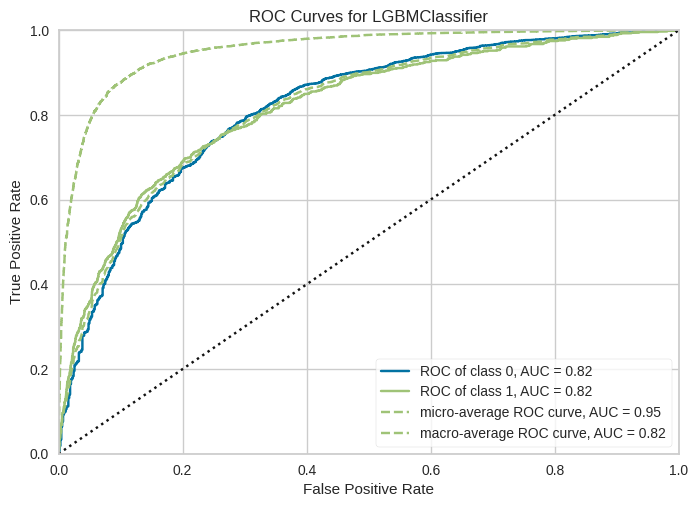

In [41]:
plot_model(tuned_lightgbm, plot = 'auc')

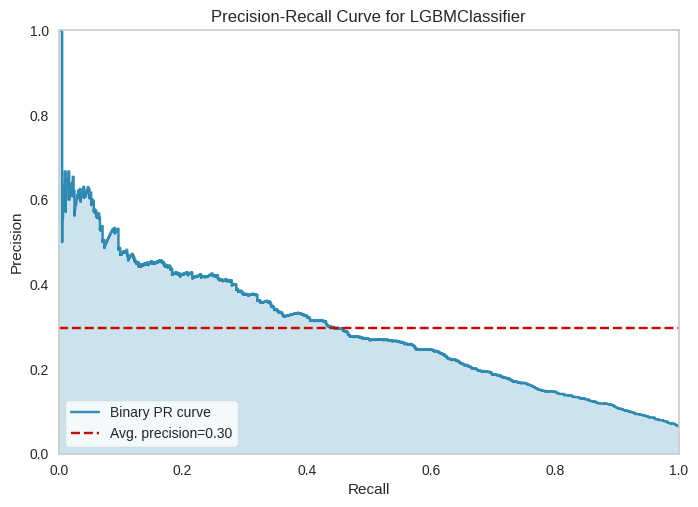

In [42]:
plot_model(tuned_lightgbm, plot = 'pr')

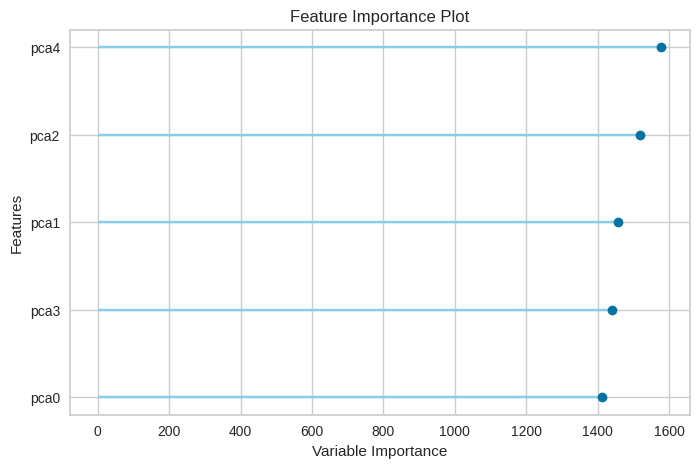

In [43]:
plot_model(tuned_lightgbm, plot = 'feature')

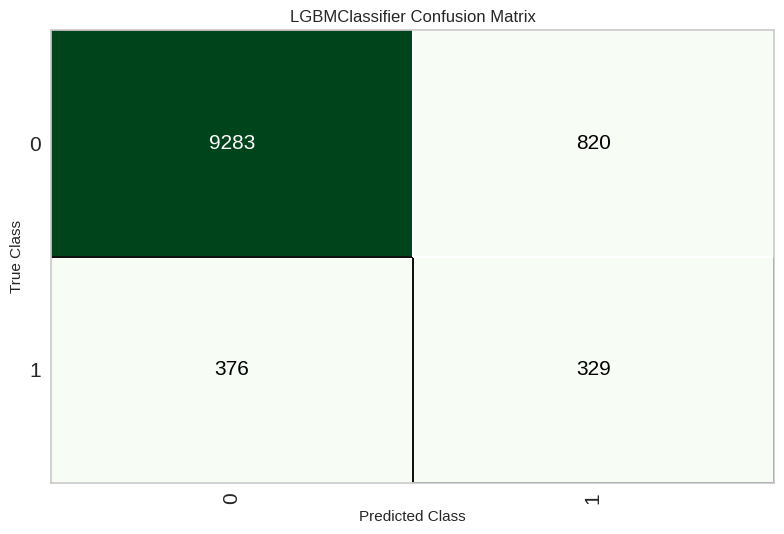

In [44]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [45]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8893,0.8177,0.4667,0.2863,0.3549,0.2982,0.3088


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,bom,tempo_emprego_norm,renda_norm,mau,prediction_label,prediction_score
319151,2015-07-01,10421,M,N,S,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,51,8.638356,2.0,38880.410156,1,0.551405,2.494667,0,0,0.9967
503392,2015-11-01,10605,F,S,S,0,Assalariado/Bolsista,Superior,Casado,Casa,42,13.243835,2.0,43971.250000,1,1.630455,2.971290,0,0,0.9996
546506,2015-11-01,11601,F,S,S,0,Assalariado/Bolsista,Superior,Casado,Casa,48,6.830137,2.0,4996.680176,1,0.127745,-0.677658,0,0,0.9510
101999,2015-03-01,7461,M,S,N,0,Pensionista,Superior,Casado,Casa,64,6.284910,2.0,4191.620117,1,0.000000,-0.753030,0,0,0.9258
333989,2015-07-01,13840,M,N,N,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Aluguel,33,9.791780,2.0,3597.370117,1,0.821649,-0.808666,0,0,0.9911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332968,2015-07-01,10691,F,N,N,0,Empresário,Fundamental/Médio,Casado,Casa,38,2.931507,2.0,3793.360107,1,-0.785692,-0.790317,0,0,0.9637
17036,2015-01-01,5413,F,N,S,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,58,12.767123,2.0,5273.379883,0,1.518763,-0.651752,1,0,0.5108
455255,2015-10-01,13653,F,N,S,0,Empresário,Superior,Solteiro,Com os pais,30,1.432877,1.0,14432.709961,1,-1.136817,0.205780,0,0,0.9988
213704,2015-05-01,14666,F,S,N,2,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,42,10.389041,4.0,9022.160156,1,0.961586,-0.300777,0,0,0.9381


In [46]:
final_lightgbm = finalize_model(tuned_lightgbm)
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda',
                                             'bom', 'tempo_emp...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.8,
                                importance_type='sp

In [47]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6807,0.7177,0.6397,0.1236,0.2072,0.1099,0.1688


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,bom,tempo_emprego_norm,renda_norm,mau,prediction_label,prediction_score
319151,2015-07-01,10421,M,N,S,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,51,8.638356,2.0,38880.410156,1,0.551405,2.494667,0,0,0.9906
503392,2015-11-01,10605,F,S,S,0,Assalariado/Bolsista,Superior,Casado,Casa,42,13.243835,2.0,43971.250000,1,1.630455,2.971290,0,0,0.9952
546506,2015-11-01,11601,F,S,S,0,Assalariado/Bolsista,Superior,Casado,Casa,48,6.830137,2.0,4996.680176,1,0.127745,-0.677658,0,0,0.7531
101999,2015-03-01,7461,M,S,N,0,Pensionista,Superior,Casado,Casa,64,6.284910,2.0,4191.620117,1,0.000000,-0.753030,0,0,0.8643
333989,2015-07-01,13840,M,N,N,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Aluguel,33,9.791780,2.0,3597.370117,1,0.821649,-0.808666,0,0,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332968,2015-07-01,10691,F,N,N,0,Empresário,Fundamental/Médio,Casado,Casa,38,2.931507,2.0,3793.360107,1,-0.785692,-0.790317,0,1,0.5285
17036,2015-01-01,5413,F,N,S,0,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,58,12.767123,2.0,5273.379883,0,1.518763,-0.651752,1,0,0.8681
455255,2015-10-01,13653,F,N,S,0,Empresário,Superior,Solteiro,Com os pais,30,1.432877,1.0,14432.709961,1,-1.136817,0.205780,0,1,0.6341
213704,2015-05-01,14666,F,S,N,2,Assalariado/Bolsista,Fundamental/Médio,Casado,Casa,42,10.389041,4.0,9022.160156,1,0.961586,-0.300777,0,0,0.9560


In [48]:
df_oot2['bom'] = 1-df_oot2.mau
unseen_predictions = predict_model(lightgbm, data=df_oot2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7544,0.7883,0.6576,0.3346,0.4435,0.3068,0.3356


In [49]:
from pycaret.utils.generic import check_metric
check_metric(unseen_predictions['mau'], unseen_predictions['prediction_label'], metric = 'Accuracy')

0.7544

In [50]:
save_model(final_lightgbm,'Final GBC Model 17Nov2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda',
                                              'bom', 'tempo_emp...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.8,
                                 impo